# **Hierarcial Risk Parity (HRP) for machine learning asset allocation:**

## Introduction:



Markowitz critical line algorithm has 3 critical issues : 


*   Instability
*   Concentration 
*   Under performance

These problems are address these concerns by applying modern mathematics (graph theory and machine learning) to build a diversified portfolio based on the information contained in the covariance matrix.

A practical application of HRP is to determine allocations across multiple machine learning (ML) algorithm.

Portfolio constructionn is perhaps the most reccurent financial problemes. on a daily basis, investment managers must build portfolios that incorporate their vies and forecast on risk and returns. As Markowitz highligthed with his work it is rarely optimal to allocate assets to the investment with highest expected returns as we should take the correlations between assets into account.

Given that returns can rarely be forecasted with enough certainty, people have decided to focus on the covariance matrix. This has led to risk-based asset allocation methods amoing which risk parity is prominent.
Although getting rid of forecast on returns improves the instability issue, it doesn't prevent it. Why? The inversion of the covariance matrix in quadratic programming methods is prone to large errors. This is known as the Markowitz's curse: the more correlated the investments, the greater the need for diversification and yet the more likely we will recceive unstable solutions.
Note that benefits of diversifications is most of the time off-set by estimations errors.


### From geometric to  hierarical relationships:

One reason for the instability of quadratic optimizers is that the vector space is modelled as complete (fully connected) graph, where every node is a potential candidate to substitute another.

![realtionships implied by covariance matrix of graph](https://upload.wikimedia.org/wikipedia/commons/1/14/E8Petrie.svg)
.


Actually, correlation matrices lack the notion of hierarchy whcih as for consequence to allow weights to vary freely sometimes in unintended ways (root of CLA instability).


To counter this instability, we would like to come up with a strucutre that has
* only N-1 edges to connect N nodes
* weights are distributed top-down (ex : from asset class to inidvidual security).
These are known tree-graph.

![Tree graph strucutre | 512x397,20%](https://i2.wp.com/angularscript.com/wp-content/uploads/2016/06/Angular-Bubble-Tree-Chart-Module.png?w=2120&ssl=1)
.

Don't pay attention to the things written on the picture. I seelcted the picture for its structure rather it highlights.

Note that the HRP method doesn't require the covariance matrix to be definite and positive neither inversible.

HRP algorithm is divided in 3 steps:


1.   tree clustring
2.   quasi diagonalization
3.   recursive bisection




## Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

!pip install yfinance
import yfinance as yf


## Import dataset

In [2]:
Tickers = ['NOW', 'MSCI', 'GE', 'RMD', 'BIO', 'APD', 'MPC', 'BKNG'] #my portfolio tickers (arbitrary in SP500 list)
historical_data = yf.download(tickers= Tickers, period = "5y",group_by='ticker')

[*********************100%***********************]  8 of 8 completed


In [3]:
# Maching companies to adjusted return only
adj_close = pd.DataFrame()
for name in Tickers:
    adj_close[name] = historical_data[name]['Adj Close'] 

In [4]:
monthly_returns = adj_close.resample('M').last().pct_change().dropna(how='all')
monthly_returns = monthly_returns.dropna(axis=1)
monthly_returns.columns.names = ['Ticker']
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59 entries, 2016-03-31 to 2021-01-31
Freq: M
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NOW     59 non-null     float64
 1   MSCI    59 non-null     float64
 2   GE      59 non-null     float64
 3   RMD     59 non-null     float64
 4   BIO     59 non-null     float64
 5   APD     59 non-null     float64
 6   MPC     59 non-null     float64
 7   BKNG    59 non-null     float64
dtypes: float64(8)
memory usage: 4.1 KB


## Tree Clustering 

Consider the returns of N assets over T periods.


1.   Compute correlation matrix
2.   Define a distance (ex: $d[X_i, X_j] = \sqrt{\frac{1}{2}(1-\rho_{i,j})}$ and compute the corresponding distance matrix. Distances are non negatives and the matrice is symetric.
3. Compute the Euclidean distance between any two column-vectors (it gives another matrix).
4. We cluster together the pair of columns $(i^*, j^*)$ such that $(i^*, j^*) = argmin(i, j)_{i≠j}$
5. Define the distance between the newly formed cluster and the unclestered items (this process=linkage criterion)
6. Euclidean formed matrice is updated by appending $d_{i, u[1]}$ and dropping the clustered columns and rows  j include in u[1].
7. Applied steps 4, 5 and 6 recursively to form N-1 clusters.





In [5]:
cov = monthly_returns.cov()
corr = monthly_returns.corr()
corr.columns.names=['Ticker']

In [6]:
heat = go.Heatmap(z=corr,
                  x=monthly_returns.columns,
                  y=monthly_returns.columns,
                  xgap=1, ygap=1,
                  colorscale=px.colors.diverging.BrBG,
                  colorbar_thickness=20,
                  colorbar_ticklen=3,
                  hoverinfo='text'
                   )


title = 'Correlation Matrix'               

layout = go.Layout(title_text=title, title_x=0.5, 
                   width=600, height=600,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   yaxis_autorange='reversed')
   
fig=go.Figure(data=[heat], layout=layout)        
fig.show() 

In [7]:
def get_distance_matrix(corr):
    """Compute distance matrix from correlation; 
        0 <= d[i,j] <= 1""" 
    return np.sqrt((1 - corr) / 2)

In [8]:
dist_matrix = get_distance_matrix(corr)
linkage_matrix = linkage(squareform(dist_matrix), 'single')

In [9]:
print(linkage_matrix)

[[ 6.          7.          0.42716755  2.        ]
 [ 0.          1.          0.50628138  2.        ]
 [ 5.          9.          0.51543822  3.        ]
 [ 2.          8.          0.51632018  3.        ]
 [ 4.         10.          0.53936916  4.        ]
 [11.         12.          0.53968229  7.        ]
 [ 3.         13.          0.59443928  8.        ]]


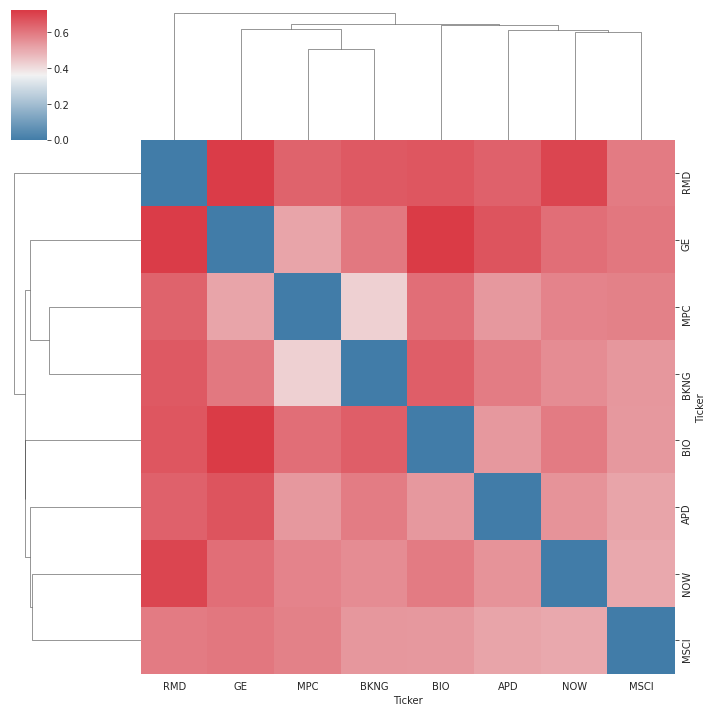

In [10]:
cmap = sns.diverging_palette(240, 10, n=4, as_cmap=True)
clustergrid = sns.clustermap(dist_matrix, 
                             method='single', 
                             row_linkage=linkage_matrix, 
                             col_linkage=linkage_matrix, 
                             cmap=cmap);

## Quasi-Diagonalization

The purpose of this step is to have the largest values lie along the diagonal(without requiring a change of basis).
This way similar investment are grouped together while dissimilar investments are far apart.

The linkage matrix consist in a (N-1)x4 matrix with structure $T = {(y_{m,1}, y_{m,2}, y_{m,3}, y_{m,4})}$ (ie: 4-tuple per cluster).

Since we know the linkage matrix merges two branches into one, it only consists in replacing $(y_{m,1}, y_{m,2})$ with their constituents recursively., until no clusters remain.
The output is a sorted list of (unclestered) items.

In [11]:

def quasi_diagonalize(link):
    """sort clustered assets by distance"""
    link = link.astype(int)
    sort_idx = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # idx of original items
    while sort_idx.max() >= num_items:
        sort_idx.index = list(range(0, sort_idx.shape[0] * 2, 2))  # make space
        df0 = sort_idx[sort_idx >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_idx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sort_idx = sort_idx.append(df0)  # item 2
        sort_idx = sort_idx.sort_index()  # re-sort
        sort_idx.index = list(range(sort_idx.shape[0]))  # re-index
    return sort_idx.tolist()

In [12]:
sorted_index = quasi_diagonalize(linkage_matrix)


In [13]:
print(sorted_index)

[3, 2, 6, 7, 4, 5, 0, 1]


In [14]:
sorted_tickers = corr.index[sorted_index].tolist()

In [15]:
print('New order: {}'.format(sorted_tickers))
print('Initial order: {}'.format(Tickers))

New order: ['RMD', 'GE', 'MPC', 'BKNG', 'BIO', 'APD', 'NOW', 'MSCI']
Initial order: ['NOW', 'MSCI', 'GE', 'RMD', 'BIO', 'APD', 'MPC', 'BKNG']


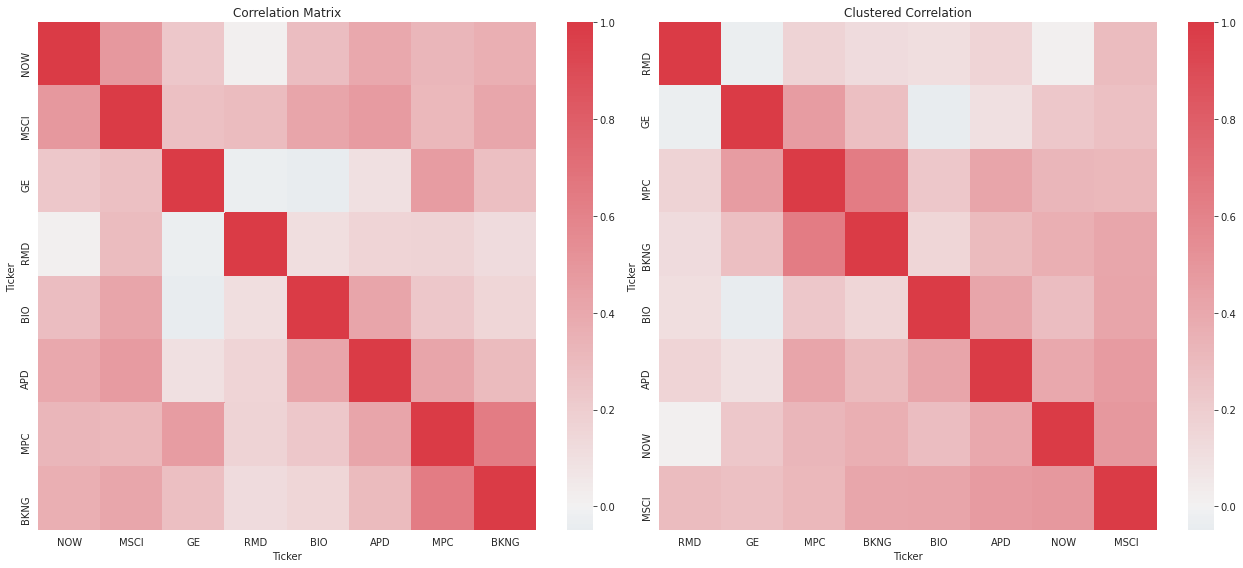

In [16]:

fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
cmap = sns.diverging_palette(240, 10, n=4, as_cmap=True)

sns.heatmap(corr, center = 0, cmap = cmap, ax=axes[0])
axes[0].set_title('Correlation Matrix')
fig.tight_layout()

clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder
sns.heatmap(clustered_assets, center = 0, cmap = cmap, ax=axes[1])
axes[1].set_title('Clustered Correlation')
fig.tight_layout();

## Recursive Diagonalization

Knowing that the inverse-variance allocation is optimal for a diagonal covariance matrix, we can do to things:



1.  Define the variance of a continguous subset as the variance of an inverse-variance allocation (bottom-up) 
2.   Split allocation between adjacent subset in inverse proportion to their aggregated variances

This way we mke sure that we are splitting the weights received from higher hierarical levels and that the sums of all weights is equal to 1.





In [17]:
def get_inverse_variance_portfolio(cov, **kargs):
    """Compute the inverse-variance portfolio""" 
    ivp = 1 / np.diag(cov)
    return ivp / ivp.sum()

In [18]:
def get_cluster_var(cov, cluster_items):
    """Compute variance per cluster"""
    cov_ = cov.loc[cluster_items, cluster_items]  # matrix slice
    w_ = get_inverse_variance_portfolio(cov_)
    return (w_ @ cov_ @ w_).item()

In [65]:
def get_hrp_allocation(m_cov, sIndex):
    """Compute top-down HRP weights"""

    tickers = m_cov.index[sIndex].tolist()
    weights = pd.Series(1, index=tickers)
    clusters = [tickers]  # initialize one cluster with all assets
    
    while len(clusters) > 0:
        # run bisectional search:
        clusters = [c[start:stop] for c in clusters
                    for start, stop in ((0, int(len(c) / 2)),
                                        (int(len(c) / 2), len(c)))
                    if len(c) > 1]

        for i in range(0, len(clusters), 2):  # parse in pairs
            cluster0 = clusters[i]
            cluster1 = clusters[i + 1]

            cluster0_var = get_cluster_var(m_cov, cluster0)
            cluster1_var = get_cluster_var(m_cov, cluster1)
    
            weight_scaler = 1 - cluster0_var / (cluster0_var + cluster1_var)
            weights[cluster0] *= weight_scaler
            weights[cluster1] *= 1 - weight_scaler

    return weights

In [20]:

hrp_allocation = get_hrp_allocation(cov, sorted_index)*100


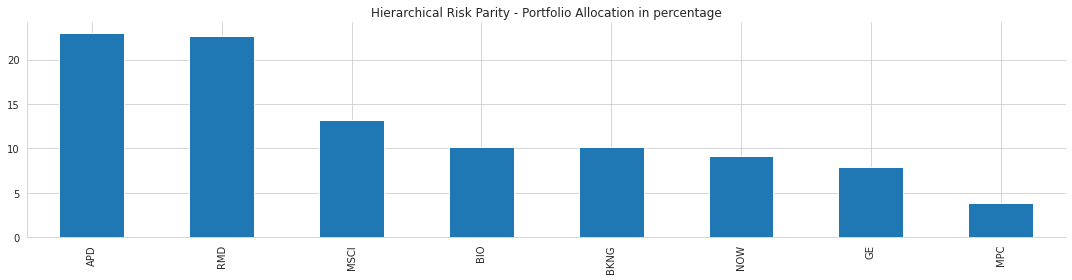

In [21]:

title = 'Hierarchical Risk Parity - Portfolio Allocation in percentage'
hrp_allocation.sort_values(ascending=False).iloc[:].plot.bar(figsize=(15, 4),
                                                               title=title)
sns.despine()
plt.tight_layout()

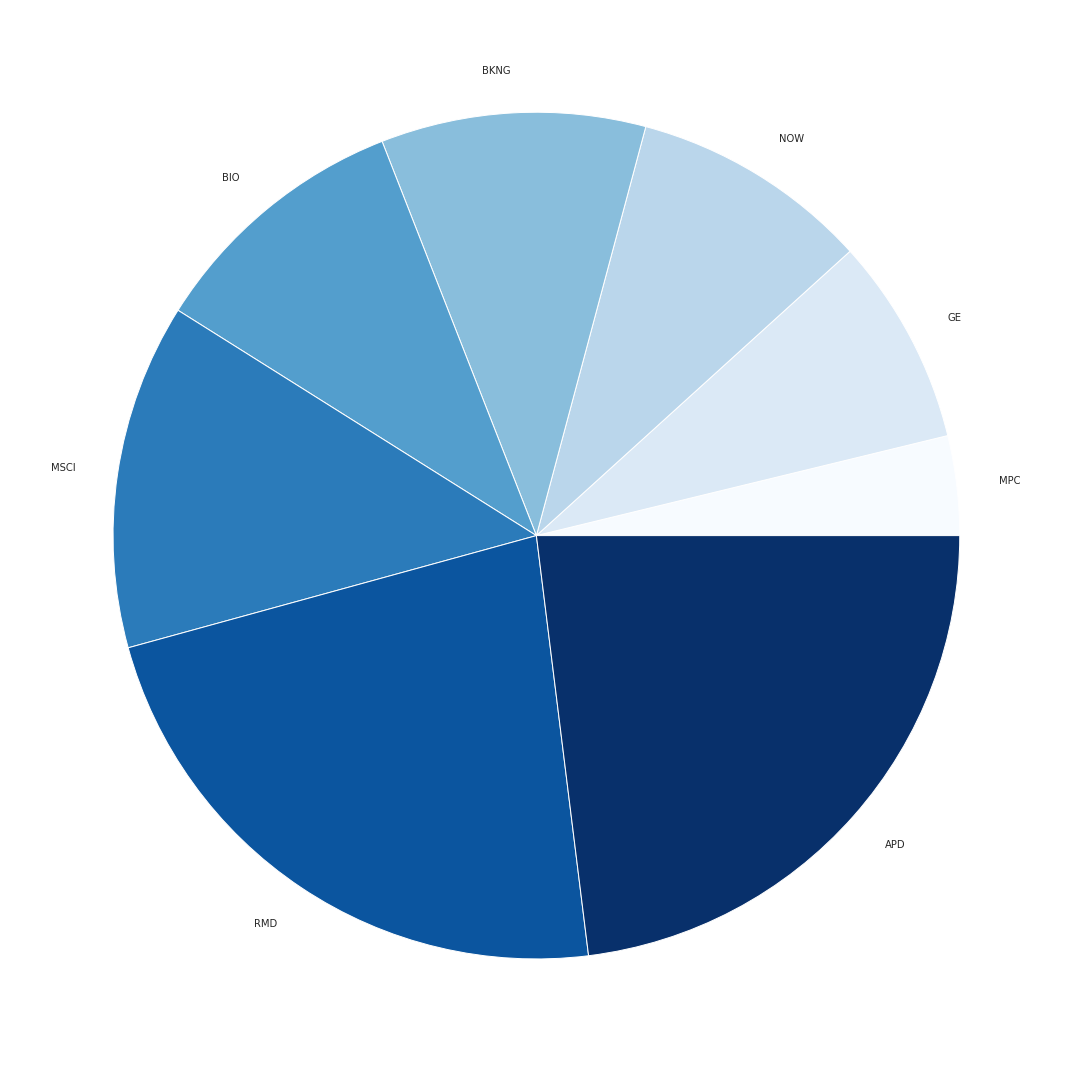

In [22]:
ax = hrp_allocation.sort_values().plot.pie(figsize=(15, 15), 
                                      cmap='Blues')
ax.set_ylabel('')
plt.tight_layout();


## Test on Russel 1000 index

It is not very useful to use HRP on such a big index but I would like to show the scalability of the algorithm.



In [23]:
# Libraries to perform web scraping
import bs4
import requests

### Getting Russel 100 list of tickers

In [24]:
# Get tickers ( companies' symbol), name and sector from wikipedia
def get_index_info(): 
    
  # Get html from the web page      
  response = requests.get( "https://en.wikipedia.org/wiki/Russell_1000_Index" ) 
  # Make the html readable
  soup = bs4.BeautifulSoup(response.text)
 
  # This selects the first table, using CSS Selector syntax and then ignores the header row ([1:]) 
  list_Russel = soup.select('table')[2].select('tr')[1:]
  # Obtain the symbol information for each row in the S&P500 constituent table 
  info = [] 
  for i, symbol in enumerate(list_Russel): 
    tds = symbol.select('td')

    info.append((tds[0].text, # compagny 
                    tds[1].text.replace('\n',''), # Ticker
                    )) 
  
  df_info = pd.DataFrame(info, columns = ['Compagny', 'Ticker'])
 
  return df_info
 

In [25]:
df_info = get_index_info()

### Dowloading the data

In [27]:
historical_data_2 = yf.download(tickers= df_info.Ticker.values.tolist(), period = "5y",group_by='ticker')

[*********************100%***********************]  967 of 967 completed

38 Failed downloads:
- ZAYO: No data found, symbol may be delisted
- S: No data found, symbol may be delisted
- LGF.A: No data found, symbol may be delisted
- LPT: No data found, symbol may be delisted
- DPS: No data found for this date range, symbol may be delisted
- HEI.A: No data found, symbol may be delisted
- LEN.B: No data found for this date range, symbol may be delisted
- FDC: No data found, symbol may be delisted
- UTX: No data found, symbol may be delisted
- USG: No data found, symbol may be delisted
- AGN: No data found, symbol may be delisted
- MSG: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- BFB: No data found, symbol may be delisted
- LOGM: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- JEC: No data found, symbol may be delisted
- ULTI: No data found, symbol may be delisted
- STI: No data found, symbol may be delisted


In [28]:
# Maching companies to adjusted return only
adj_close_2 = pd.DataFrame()
for name in df_info.Ticker.values:
    adj_close_2[name] = historical_data_2[name]['Adj Close']


In [ ]:
adj_close_2.head()

In [30]:
prices = adj_close_2[1:]

In [31]:
prices.tail()

,TWOU,MMM,ABT,ABBV,ABMD,ACHC,ACN,ATVI,AYI,ADNT,ADBE,ADT,AAP,AMD,ACM,AES,AMG,AFL,AGCO,A,AGIO,AGNC,AL,APD,AKAM,ALK,ALB,AA,ARE,ALXN,ALGN,ALKS,Y,ALLE,AGN,ADS,LNT,ALSN,ALL,ALLY,...,WY,WHR,WTM,WLL,JW.A,WMB,WSM,WLTW,WTFC,WDAY,WP,WPX,WYND,WH,VIAB,VICI,VIRT,V,VC,VST,VMW,VNO,VOYA,ZAYO,ZBRA,ZEN,ZG,Z,ZBH,ZION,ZTS,ZNGA,WYNN,XEL,XRX,XLNX,XPO,XYL,YUMC,YUM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-25,43.209999,170.389999,114.720001,110.500000,348.320007,51.660000,252.039993,93.400002,124.199997,33.750000,473.440002,8.90,159.660004,94.129997,53.660000,26.057493,113.680000,46.570000,112.139999,125.480003,49.500000,16.126503,42.799999,279.019989,111.330002,52.900002,176.919998,19.340000,169.479996,161.320007,539.469971,22.870001,586.570007,112.089996,NaN,69.260002,50.084496,45.180000,110.949997,39.166058,...,33.500000,203.020004,1018.419983,23.940001,NaN,21.660000,132.559998,209.320007,65.209999,234.990005,NaN,NaN,47.029999,59.669998,NaN,26.250000,26.299999,200.979996,136.449997,20.850000,136.279999,38.269989,57.009998,NaN,402.630005,147.119995,152.880005,146.860001,159.309998,47.209999,161.339996,10.32,108.059998,66.500000,20.750000,145.139999,119.500000,101.000000,58.369999,105.260002
2021-01-26,42.810001,175.949997,114.730003,108.800003,340.890015,51.080002,252.990005,92.379997,122.910004,32.770000,476.279999,9.97,157.630005,94.709999,53.070000,24.398478,115.599998,46.430000,111.070000,123.919998,48.040001,16.037188,41.900002,277.989990,117.000000,51.830002,175.380005,18.559999,169.009995,161.750000,535.099976,21.690001,580.159973,111.260002,NaN,68.599998,49.429924,45.310001,109.519997,38.489410,...,33.139999,206.419998,1015.010010,22.059999,NaN,21.440001,136.399994,210.220001,63.950001,235.600006,NaN,NaN,46.349998,60.279999,NaN,26.070000,26.190001,202.009995,131.589996,20.799999,140.580002,38.644993,56.599998,NaN,395.160004,145.360001,145.679993,139.270004,158.220001,46.049999,159.710007,10.37,105.910004,65.809998,21.070000,144.389999,118.989998,99.230003,59.340000,106.339996
2021-01-27,40.290001,186.649994,114.290001,102.790001,328.600006,49.540001,246.100006,88.669998,131.020004,31.309999,460.000000,10.21,147.929993,88.839996,50.480000,22.808998,115.290001,45.150002,102.800003,118.800003,45.840000,15.669999,40.480000,269.980011,120.440002,48.849998,168.850006,18.660000,166.240005,155.690002,509.640015,21.540001,564.760010,112.150002,NaN,67.580002,48.577000,44.669998,110.510002,36.270397,...,32.200001,212.399994,1025.000000,21.100000,NaN,21.209999,147.600006,205.970001,61.360001,223.449997,NaN,NaN,44.139999,57.340000,NaN,24.750000,27.440001,194.970001,126.519997,20.180000,145.460007,39.108814,55.090000,NaN,391.359985,135.690002,136.089996,127.470001,152.600006,43.810001,153.149994,9.89,100.800003,63.820000,20.870001,133.860001,113.550003,97.949997,58.070000,102.019997
2021-01-28,41.029999,183.419998,120.389999,104.209999,355.130005,50.889999,249.339996,90.269997,124.080002,32.910000,465.670013,9.63,153.339996,87.519997,50.959999,24.549999,113.860001,46.119999,112.430000,121.559998,45.439999,15.820000,42.060001,275.859985,112.779999,50.669998,166.369995,18.500000,167.339996,157.289993,536.580017,21.200001,578.700012,110.480003,NaN,70.790001,48.959999,43.590000,109.300003,38.370003,...,33.020000,194.600006,1042.260010,21.340000,NaN,21.459999,133.919998,206.309998,62.299999,228.559998,NaN,NaN,45.970001,59.910000,NaN,25.850000,26.950001,198.220001,128.850006,20.180000,140.289993,39.770000,56.750000,NaN,393.029999,144.070007,141.720001,132.350006,157.029999,45.169998,156.529999,9.85,102.050003,63.639999,21.219999,133.570007,114.669998,99.089996,57.020000,102.529999
2021-01-29,40.900002,175.660004,123.589996,102.480003,348.250000,50.680000,241.919998,91.000000,120.239998,32.290001,458.769989,9.03,149.139999,85.639999,50.099998,24.389999,110.190002,45.180000,110.900002,120.169998,46.970001,15.600000,39.630001,266.760010,111.029999,48.830002,162.660004,18.000000,167.110001,153.330002,525.380005,20

### Dropping invalid column

In [32]:
# drop column where there are nans.
# for instance, nans might occurs if the compagny wasn't traded in the last 5 years
prices = prices.dropna(axis='columns')

In [33]:
prices.shape

(1259, 862)

We dropped around 100 stocks for whatever reasons. I don't want to lose too much time in pre-processing the data, so, dropping invalid column is the easiest.

### Compute monthly returns (downsampling)

In [39]:
monthly_returns_2 = prices.resample('M').last().pct_change().dropna(how='all')
monthly_returns_2 = monthly_returns_2.dropna(axis=1)
monthly_returns_2.columns.names = ['Ticker']
monthly_returns_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59 entries, 2016-03-31 to 2021-01-31
Freq: M
Columns: 862 entries, TWOU to YUM
dtypes: float64(862)
memory usage: 397.8 KB


### Compute covariance and correlation matrix:

In [40]:
cov_2 = monthly_returns_2.cov()
corr_2 = monthly_returns_2.corr()

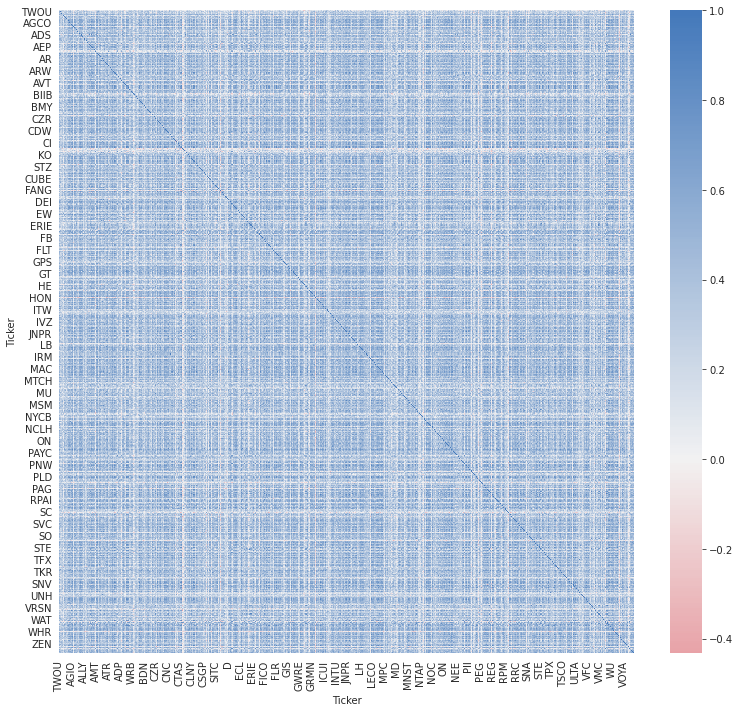

In [42]:
cmap = sns.diverging_palette(10, 250, as_cmap=True)
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(corr_2, center = 0, cmap = cmap, ax=ax)
fig.tight_layout()

### Compute Linkage matrix

In [44]:
dist_matrix_2 = get_distance_matrix(corr_2)
linkage_matrix_2 = linkage(squareform(dist_matrix_2), 'single')

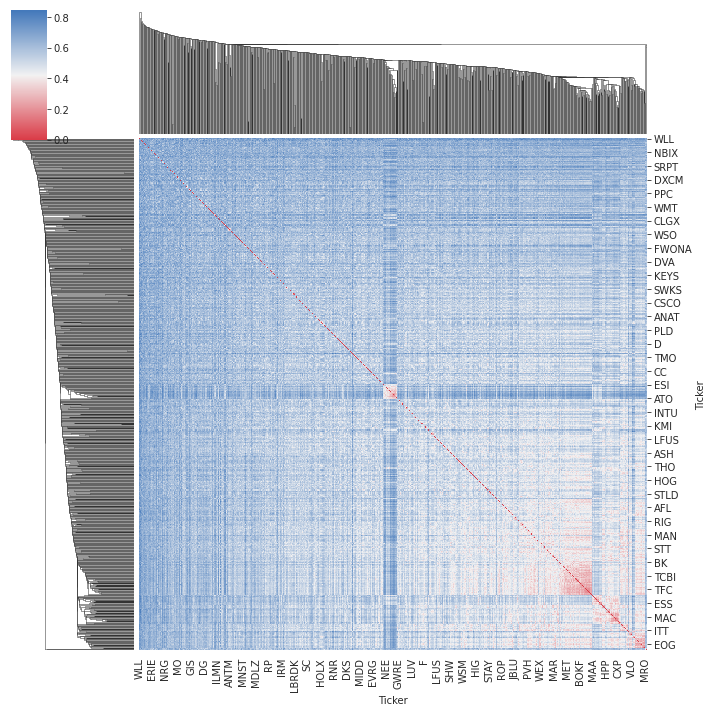

In [45]:
clustergrid = sns.clustermap(dist_matrix_2, 
                             method='single', 
                             row_linkage=linkage_matrix_2, 
                             col_linkage=linkage_matrix_2, 
                             cmap=cmap);

### Quasi diagonalization: 



In [46]:
sorted_index_2 = quasi_diagonalize(linkage_matrix_2)
print(sorted_index_2)

[834, 841, 385, 185, 642, 804, 655, 359, 22, 854, 322, 761, 634, 347, 785, 357, 660, 559, 318, 128, 0, 113, 288, 542, 253, 518, 783, 112, 539, 550, 447, 711, 762, 467, 406, 285, 337, 488, 118, 803, 649, 402, 726, 168, 561, 269, 673, 623, 547, 664, 396, 787, 742, 619, 338, 312, 849, 850, 361, 29, 404, 100, 545, 546, 506, 37, 40, 604, 748, 239, 499, 679, 376, 565, 251, 18, 119, 678, 398, 417, 770, 541, 7, 273, 317, 533, 701, 146, 342, 407, 657, 209, 606, 807, 670, 154, 739, 813, 3, 139, 797, 375, 562, 114, 11, 205, 435, 423, 228, 4, 250, 844, 806, 217, 802, 814, 494, 13, 272, 808, 733, 675, 172, 27, 448, 162, 636, 413, 508, 629, 224, 301, 401, 367, 221, 54, 674, 540, 212, 187, 765, 776, 5, 587, 632, 229, 242, 213, 284, 336, 87, 756, 176, 391, 65, 784, 44, 477, 271, 603, 255, 817, 220, 354, 746, 497, 403, 424, 341, 579, 231, 432, 137, 625, 84, 749, 522, 601, 615, 691, 268, 175, 439, 853, 463, 507, 237, 59, 527, 613, 149, 57, 501, 157, 125, 428, 106, 719, 520, 155, 131, 496, 492, 216, 858,

In [47]:
sorted_tickers_2 = corr_2.index[sorted_index_2].tolist()


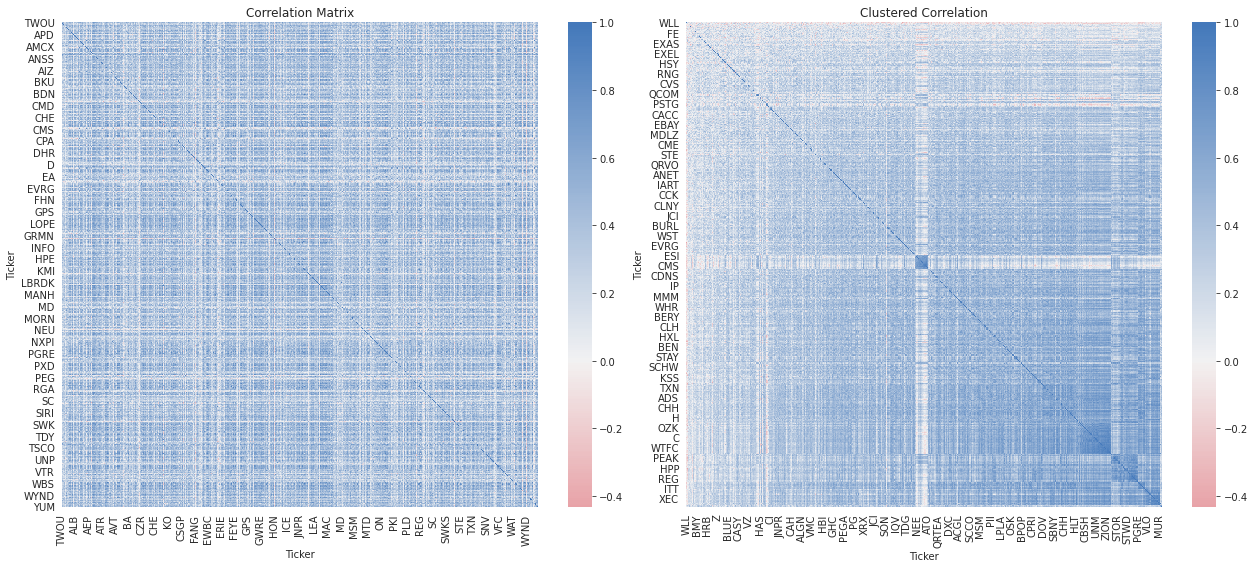

In [48]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8))

sns.heatmap(corr_2, center = 0, cmap = cmap, ax=axes[0])
axes[0].set_title('Correlation Matrix')
fig.tight_layout()

clustered_assets_2 = corr_2.loc[sorted_tickers_2, sorted_tickers_2]  # reorder
sns.heatmap(clustered_assets_2, center = 0, cmap = cmap, ax=axes[1])
axes[1].set_title('Clustered Correlation')
fig.tight_layout();

### Recurisve diagonalization

In [62]:
hrp_allocation_2 = get_hrp_allocation(cov_2, sorted_index_2)

['WLL', 'VIRT', 'HRL', 'CTXS', 'PEN', 'TWTR', 'RMD', 'GRUB', 'AKAM', 'ZNGA', 'FLO', 'THS', 'QGEN', 'GILD', 'UNIT', 'LOPE', 'ROL', 'NLOK', 'FE', 'BMY', 'TWOU', 'BMRN', 'ERIE', 'NBIX', 'DPZ', 'MOH', 'UTHR', 'BIIB', 'NKTR', 'MCY', 'KR', 'SFM', 'TPCO', 'LLY', 'INTC', 'EQC', 'EXAS', 'MKTX', 'HRB', 'VRTX', 'REGN', 'INCY', 'SGEN', 'CHE', 'NRG', 'SATS', 'SRPT', 'PGR', 'NEM', 'RGLD', 'ICUI', 'OLED', 'TSLA', 'PINC', 'EXEL', 'FEYE', 'ZG', 'Z', 'HAIN', 'ALKS', 'PODD', 'BLL', 'NWL', 'NEU', 'MRK', 'ALNY', 'MO', 'PM', 'KHC', 'DXCM', 'MKC', 'SEB', 'HSY', 'NVDA', 'DLTR', 'AGIO', 'BLUE', 'SMG', 'IDXX', 'IONS', 'TTWO', 'NFLX', 'ATVI', 'EA', 'FSLR', 'NFG', 'SJM', 'CPB', 'GIS', 'IBKR', 'RNG', 'CERN', 'PPC', 'TSN', 'SAGE', 'CASY', 'TDC', 'WBA', 'ABBV', 'CABO', 'VEEV', 'HLF', 'NUS', 'BIO', 'AMD', 'CAG', 'K', 'HRC', 'CVS', 'ABMD', 'DG', 'VMW', 'TYL', 'COST', 'VZ', 'WMT', 'MASI', 'AES', 'EW', 'UI', 'TGT', 'HSIC', 'CMG', 'ALXN', 'LB', 'CNC', 'QCOM', 'IFF', 'LSI', 'PSA', 'CUBE', 'EXR', 'ILMN', 'HAS', 'CCI', 'AMT

In [63]:
hrp_allocation_2

WLL     0.000003
VIRT    0.001726
HRL     0.007273
CTXS    0.006060
PEN     0.002335
          ...   
DVN     0.000104
MRO     0.000191
JKHY    0.002532
FTNT    0.000542
SPLK    0.000437
Length: 862, dtype: float64

### Results

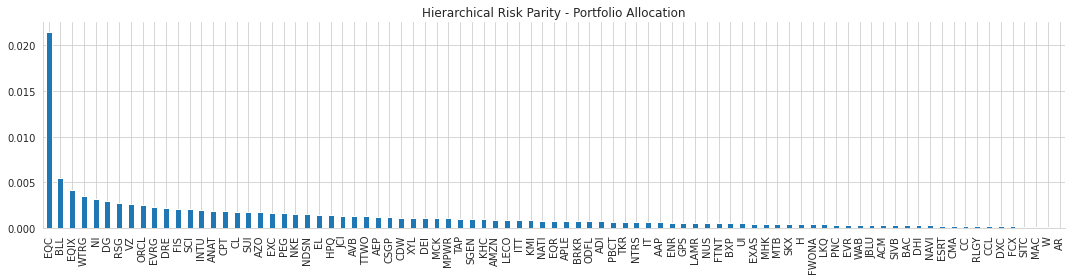

In [69]:
title = 'Hierarchical Risk Parity - Portfolio Allocation'
hrp_allocation_2.sort_values(ascending=False).iloc[::10].plot.bar(figsize=(15, 4),
                                                               title=title)
sns.despine()
plt.tight_layout()

### Make it a single function

In [ ]:
def HRP_allocation (returns):
  """ Return the allocation resultion from the HRP allocation algorithm"""
  
  cov_ = returns.cov()
  corr_ = returns.corr()

  # Tree Clustering
  dist_matrix = get_distance_matrix(corr_)
  linkage_matrix = linkage(squareform(dist_matrix), 'single')

  #quasi-Diagonalization
  sorted_index = quasi_diagonalize(linkage_matrix)

  # Recursive diagonalization
  allocation = get_hrp_allocation(cov_, sorted_index)

  return allocation 

## Conclusion





Some studies have shown that the HRP method exhibits lower out-of-sample variance than traditional methods. 

According to de Prado, HRP provides better protection against common and idiosyncratic shocks by providing a diversication between assets but also clusters (sector, capitalization etc ...) of assets.

The algorithm can be modified :
* tree clustering => other clustering algorithm (biclustering)
* recursive disection => constraint on the parameter alpha for instance

PS: This is largely insipred from Marcos Lopez de Prados book "Advances in Financial Machine Learning". I am just summing up my leanrings in notebooks.